### Notebook for analysing nf pipeline output

#### Nanoseq 1a

### Sequencing information 
 - Analysis no.: A006
 - Platform: Nanoseq
 - Library preparion: NEBNext
 - Loaded: 12pM
 - Seq Date: 01-07-2021
 - Number of samples:96
 - Cluster Density: 
 - Passing Filter: 
 - Output: 77.4g
 - Fragment size: 550
 - Lib conc: 
 - Cubit 
 - Lib load start concentration: 

In [66]:
import pandas as pd

samples_df = pd.read_excel('/home/douso/Documents/SarsGenomics/nanoseq-sample-sheet-seq12.xlsx')
sample_dict = {f'{well}': f'{name}' for well, name in zip(list(samples_df['SN']), list(samples_df['SAMPLE']))}

{'Sample01': 'NHRL-S003',
 'Sample02': 'NHRL-S004',
 'Sample03': 'NHRL-S005',
 'Sample04': 'NHRL-S007',
 'Sample05': 'NHRL-S009',
 'Sample06': 'NHRL-S010',
 'Sample07': 'NHRL-S012',
 'Sample08': 'NHRL-S014',
 'Sample09': 'NHRL-S015',
 'Sample10': 'NHRL-S016',
 'Sample11': 'NHRL-S017',
 'Sample12': 'NHRL-S018',
 'Sample13': 'NHRL-S019',
 'Sample14': 'NHRL-S021',
 'Sample15': 'NHRL-S022',
 'Sample16': 'NHRL-S024',
 'Sample17': 'NHRL-S025',
 'Sample18': 'NHRL-S030',
 'Sample19': 'NHRL-S031',
 'Sample20': 'NHRL-S033',
 'Sample21': 'NHRL-S034',
 'Sample22': 'NHRL-S036',
 'Sample23': 'COVC14674',
 'Sample24': 'COVC14676',
 'Sample25': 'COVC14699',
 'Sample26': 'COVC14753',
 'Sample27': 'COVC14784',
 'Sample28': 'COVC14793',
 'Sample29': 'COVC14794',
 'Sample30': 'COVC14801',
 'Sample31': 'COVC14815',
 'Sample32': 'COVC14892',
 'Sample33': 'COVC14935',
 'Sample34': 'COVC14960',
 'Sample35': 'COVC14964',
 'Sample36': 'COVC15001',
 'Sample37': 'COVC15008',
 'Sample38': 'COVC15018',
 'Sample39':

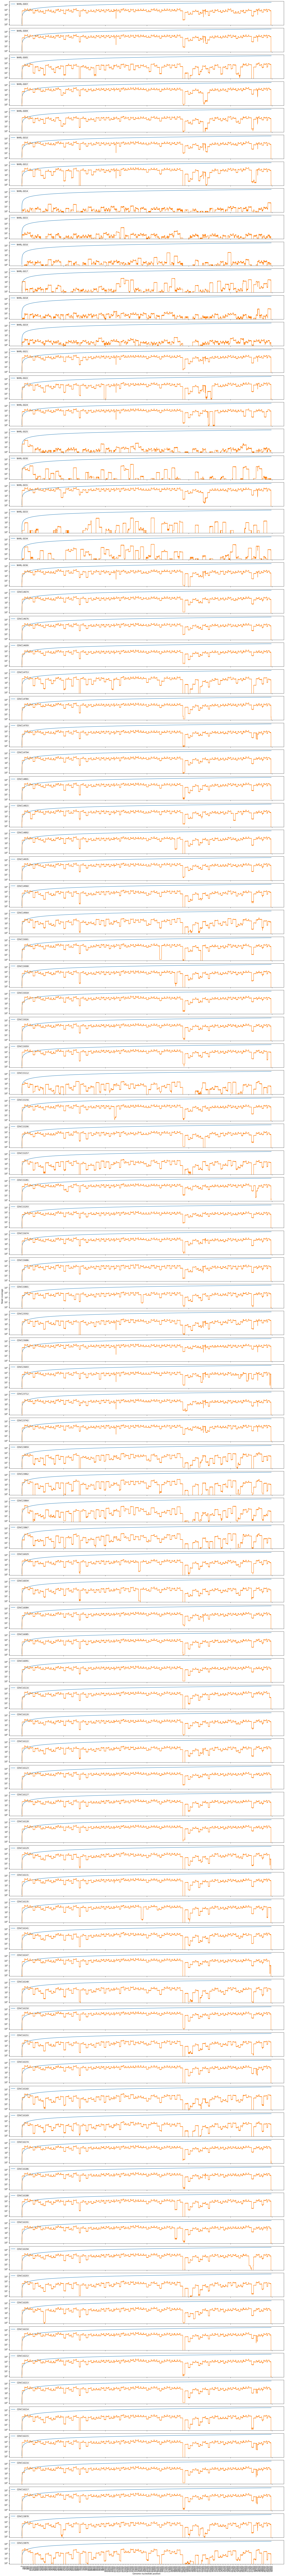

In [67]:
# plot primer depths across samples-GK
import pandas as pd, matplotlib.pyplot as plt, numpy as np, os

suffix = '.dph'
base_dir = '/home/douso/results/analysis/dpt'
files = os.listdir(f'{base_dir}')
data = []
for file in files:
    if file.endswith(suffix):
        data.append(file)
    else: pass
a = len(data)
b, c = 1, -1

fontdict = {'family': 'serif',
        'color':  'lightblue',
        'weight': 'normal',
        'size': 16,
        }

fig, axs = plt.subplots(a, b, figsize=(20,180)) 
axs[int(a/2)].set_ylabel('Read coverage')
# axs[1].set_title('Genome coverage by base')
xtick = np.arange(0, 30200, 200)
xlabel = np.arange(0, 30200, 200)

for file in sorted(data):
    c += 1
    sample_name = sample_dict[file.split('.')[0]]
    sample_df = pd.read_table(f'{base_dir}/{file}', names=['chromosome', 'region', 'coverage'])
    sample_df2 = sample_df[['region', 'coverage']]
    sample_df2.plot(logy=True, ax=axs[c], sharex=True, sharey=False) 
    axs[c].legend([sample_name], loc='upper left')

plt.xlabel('Genome nucleotide position')
# plt.ylabel('Read coverage')
plt.xticks(xtick, xlabel, rotation=90)
plt.tight_layout()
plt.show()
fig.savefig(f'{base_dir}/coverage.pdf')


## Packages

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import regex as re
import glob

In [69]:
base_dir = '/home/douso/results/analysis'
batch = 'nanoseq1a'
# dpt_dir = # ivar, samtools-depth output files
# nxt_dir = # nextclade .tsv output file
# png_dir = # pangolin .tsv output file
# var_dir = # snpEff ouput
# rmd_dir = # raw metadata - moh .xlsx spread sheet
#dpt var nxt png

### Sequencing information 
 - Analysis no.: NF-004 (batch 10)
 - Platform: Illumina MiSeq
 - Library preparion: NEBNext
 - Seq Date: MiSeq (28-05-2021)
 - Number of samples: 96
 - Sample summ: COVCs
 - VC pipeline: nextflow-viralcon, v1.0.1

## Functions

In [70]:
# define a func to replace spaces in the header names
def tidy_header(df):
    df.columns = [col.replace(' ', '_') for col in df.columns]
    return df

In [71]:
# define func to retrieve particular columns from a df (spaces in col names must be replaced with _ in the input col_list)
def get_cols(df, col_list):
    new_df = tidy_header(df)
    return new_df[col_list]

In [72]:
# define a function to replace from a dictionary ('key is what is to be replaced': 'value is the replacement')
def replace(string, substitutions):
    substrings = sorted(substitutions, key=len, reverse=True)
    regex = re.compile('|'.join(map(re.escape, substrings)))
    return regex.sub(lambda match: substitutions[match.group(0)], string)

In [73]:
# define function to merge variants and nextclade data
def merge_varNxt(df_var_cln, df_nxt_cln):
    return (df_var_cln.set_index('sample_name').merge(df_nxt_cln
          .set_index('seqName'), how='outer', left_index=True, right_index=True)
                 .reset_index().rename(columns={'index': 'sample_name'}))

In [74]:
# define function to merge pangolin and variants-nextclade data
def merge_pngVxt(df_png_cln, df_varNxt):
    return (df_png_cln.set_index('Sequence_name').merge(df_varNxt
        .set_index('sample_name'), how='outer', left_index=True, right_index=True)
            .reset_index().rename(columns={'index': 'Sequence_name'}))


In [75]:
# define function to merge metadata with cts data
def merge_rmdCts(df_rmd_cln, df_cts_cln):
    return (df_rmd_cln.set_index('S_NUM').merge(df_cts_cln.set_index('Sample_Name'), how='outer', left_index=True, right_index=True)
            .reset_index().rename(columns={'index': 'S_NUM'}))


In [76]:
# define function to merge metadata and seq data
def merge_vnpPmd(df_pngVxt, df_rmdCts):
    return (df_pngVxt.set_index('S_NUM')
            .merge(df_rmdCts.set_index('S_NUM'), how='left', left_index=True, right_index=True)
                 .reset_index().rename(columns={'index': 'S_NUM'}))

In [77]:
# define a function to retrieve MoC and all mutations for the s-gene
def get_mut_of_concern(ann_file_name, moc_list):

    def intersection(x, y):
        return list(set(x) & set(y))

    moc_list = moc_list
#     file_name = 'k-per-gene_variant_anns.tsv'
    df = ann_file_name[['sample_name','S']]

#     df = pd.read_table(f'{base_dir}/{file_name}')[['sample_name','S']]
    mutations = []
    moc = []
    sample_id = []
    for row in df.itertuples():
        if isinstance(row.S, str):
            sgene = row.S
        else: 
            sgene = str(row.S)
        substitutions = sgene.replace(' ', '').split(',')[1:-1]
        if len(moc_list) >= len(intersection(moc_list, substitutions)) > 0:
            intsct = intersection(moc_list, substitutions)
            sample_name = row.sample_name
            mutations.append(str(substitutions).replace("[", "").replace("]", "").replace("'", ""))
            moc.append(str(intsct).replace("[", "").replace("]", "").replace("'", ""))
            sample_id.append(sample_name)
        else: pass 
    df = pd.DataFrame({'Sample_ID': sample_id, 'Mut_of_Concern_(S)': moc, 'All_Mutations_(S)': mutations})
    df_fnl = df.assign(Sample_ID = df['Sample_ID'].apply(lambda x: x.split('_')[0]))
    return df_fnl

### Variants data

In [78]:
# import the collated file for all the snpEff outputs
df_var = pd.read_table(f'{base_dir}/var/per-gene_variant_anns.tsv')
df_var_fnl = df_var.assign(sample_name = df_var['sample_name'].apply(lambda x: x.split('_')[0]))

In [79]:
df_var_fnl.head()

,sample_name,num_vars,ORF1ab,ORF1a,S,ORF3a,ORF3b,E,M,ORF6,ORF7a,ORF7b,ORF8,N,ORF9a,ORF9b,ORF10
0,NHRL-S003,33,"S216S, F924F, T1001I, V1143F, A1708D, F1907F, ...",NaN,"H69_V70del, Y145del, N501Y, A570D, D614G, P681...",NaN,NaN,NaN,L124L,NaN,NaN,NaN,"F6F, Q27*, R52I, Y73C","D3L, RG203KR, S235F, Q389Q",NaN,NaN,NaN
1,NHRL-S004,32,"S216S, L730F, F924F, T1001I, A1708D, F1907F, I...",NaN,"H69_V70del, D138H, Y145del, F490S, N501Y, A570...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Q27*, R52I, Y73C","D3L, RG203KR, S235F, G236V, P279L",NaN,NaN,NaN
2,NHRL-S005,33,"N126N, T265I, F924F, P1207S, I1301V, M1647I, F...",NaN,"R246K, F562F, D614G, N679K, F888L","Q57H, G172V, G224R, N234fs, P240fs, H247fs",NaN,NaN,F53F,NaN,NaN,NaN,NaN,"D22Y, R195K, S197L, T198P",NaN,NaN,NaN
3,NHRL-S007,41,"P309L, G334G, T587T, F924F, N1578N, P1640L, A3...",NaN,"T19R, D80H, P82S, P82P, T95T, E156_F157delinsV...","S26L, V228V",NaN,NaN,I82T,NaN,"V82A, L116F, T120I",NaN,D119_F120del,"R203M, D377Y",NaN,NaN,NaN
4,NHRL-S009,39,"Y136Y, P309L, G334G, F924F, T1581T, P1640L, A3...",NaN,"T19R, V62_F133del, E156_R158delinsG, L452R, T4...","S26L, V228V",NaN,NaN,I82T,NaN,"V82A, L116F, T120I",NaN,D119_F120del,"R203M, D377Y",NaN,NaN,NaN


### Nextclade data

In [80]:
# import Nextclade clade data
df_nxt = pd.read_table(f'{base_dir}/nxt/nxt.tsv')

# retrieve cols seqName and clade (func get_cols replaces col name spaces with _)
cols = ['seqName', 'clade', 'totalMissing']
df_nxt_cln = get_cols(df_nxt, cols)
coverage = round(100 - (df_nxt_cln['totalMissing'] / 29903) * 100, 1)
df_nxt_cln1 = df_nxt_cln.assign(seqName = df_nxt_cln['seqName'].apply(lambda x: x.split('_')[0]))
df_nxt_fnl = df_nxt_cln1.assign(coverage = coverage).drop('totalMissing', axis=1)

In [81]:
df_nxt_fnl.head()

,seqName,clade,coverage
0,NHRL-S003,20I/501Y.V1,100.0
1,NHRL-S004,20I/501Y.V1,100.0
2,NHRL-S005,20C,100.0
3,NHRL-S007,20A,100.0
4,NHRL-S009,20A,100.0


### Pangolin data v.3.1.5 (15-07-2021) Ran: 13-07-2021

In [82]:
# import Pangolin lineage data
df_png = pd.read_csv(f'{base_dir}/png/png.csv', header=0)
# base_dir_pango = '/home/ouso/nextclade_files/batch2/nextclade_files_04-04-2021_11:25'
# file_name_pango = 'consensus_pango.xlsx'

# df_png = pd.read_excel(f'{base_dir_pango}/{file_name_pango}')
months = {'January': 'Jan', 'February': 'Feb', 'March': 'Mar',
         'April': 'Apr', 'June': 'Jun', 'July': 'Jul', 'August': 'Aug',
          'September': 'Sep', 'October': 'Oct', 'November': 'Nov', 'December': 'Dec'}
# retrieve cols Sequence_name and Lineage (func get_cols replaces col names spaces with _)
cols = ['Sequence_name', 'Lineage', 'Scorpio_call']#, 'Most_common_countries']
df_png_cln = get_cols(tidy_header(df_png), cols)
df_png_fnl = df_png_cln.assign(Sequence_name = df_png_cln['Sequence_name'].apply(lambda x: x.split('_')[0]))
# df_png_fnl = df_png_cln1.assign(Date_range=df_png_cln1['Date_range'].apply(lambda x: replace(x, months) if (isinstance(x, str)) else x))

In [83]:
df_png_fnl.head()

,Sequence_name,Lineage,Scorpio_call
0,NHRL-S003,B.1.1.7,Alpha (B.1.1.7-like)
1,NHRL-S004,B.1.1.7,Alpha (B.1.1.7-like)
2,NHRL-S005,B.1.429,NaN
3,NHRL-S007,B.1.617.2,Delta (B.1.617.2-like)
4,NHRL-S009,B.1.617.2,Delta (B.1.617.2-like)


# Metadata

In [84]:
# import raw metadata file
import pandas as pd
mbase_dir = '/home/douso/Documents/TrendData/Results/ResultsMerged'
df_rmd_cln = pd.read_excel(f'{mbase_dir}/COVID19-results-merged-cln.xlsx')

In [85]:
df_rmd_cln.head()

,S_NUM,AGE_YRS,GEND,OCCU,NAT,COUNT_RES,S_COUNT_RES,TRAV_HIST,TRAV_FROM,QUAR_PLACE,SYMPS,DT_SAM_COLL,DT_SAM_RECEP,RESULT,DT_CONF
0,COVC00001,35.0,F,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaN,NaN,Negative,02-06-2020
1,COVC00002,29.0,M,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaN,NaN,Negative,02-06-2020
2,COVC00003,50.0,M,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaN,NaN,Negative,02-06-2020
3,COVC00004,35.0,F,Casual,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaN,NaN,Negative,02-06-2020
4,COVC00005,27.0,F,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaN,NaN,Negative,02-06-2020


### Ct data

In [86]:
# import Ct data from sheet2 of the metadata file
ctbase_dir = '/home/douso/Documents/RunSheets/Cts'
df_cts = pd.read_excel(f'{ctbase_dir}/runsheet-cts.xlsx')

In [87]:
df_cts.head()

,Sample_Name,Ct_Mean
0,COVC00137,37.6
1,COVC00154,35.2
2,COVC00744,34.7
3,COVC00762,36.0
4,COVC00767,34.1


### **Combining data**

#### Merge Variants and Nextclade data

In [88]:
# merge the nextclade data to the pangolin data
df_varNxt = merge_varNxt(df_var_fnl, df_nxt_fnl)

In [89]:
df_varNxt.head()

,sample_name,num_vars,ORF1ab,ORF1a,S,ORF3a,ORF3b,E,M,ORF6,ORF7a,ORF7b,ORF8,N,ORF9a,ORF9b,ORF10,clade,coverage
0,NHRL-S003,33,"S216S, F924F, T1001I, V1143F, A1708D, F1907F, ...",NaN,"H69_V70del, Y145del, N501Y, A570D, D614G, P681...",NaN,NaN,NaN,L124L,NaN,NaN,NaN,"F6F, Q27*, R52I, Y73C","D3L, RG203KR, S235F, Q389Q",NaN,NaN,NaN,20I/501Y.V1,100.0
1,NHRL-S004,32,"S216S, L730F, F924F, T1001I, A1708D, F1907F, I...",NaN,"H69_V70del, D138H, Y145del, F490S, N501Y, A570...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,"Q27*, R52I, Y73C","D3L, RG203KR, S235F, G236V, P279L",NaN,NaN,NaN,20I/501Y.V1,100.0
2,NHRL-S005,33,"N126N, T265I, F924F, P1207S, I1301V, M1647I, F...",NaN,"R246K, F562F, D614G, N679K, F888L","Q57H, G172V, G224R, N234fs, P240fs, H247fs",NaN,NaN,F53F,NaN,NaN,NaN,NaN,"D22Y, R195K, S197L, T198P",NaN,NaN,NaN,20C,100.0
3,NHRL-S007,41,"P309L, G334G, T587T, F924F, N1578N, P1640L, A3...",NaN,"T19R, D80H, P82S, P82P, T95T, E156_F157delinsV...","S26L, V228V",NaN,NaN,I82T,NaN,"V82A, L116F, T120I",NaN,D119_F120del,"R203M, D377Y",NaN,NaN,NaN,20A,100.0
4,NHRL-S009,39,"Y136Y, P309L, G334G, F924F, T1581T, P1640L, A3...",NaN,"T19R, V62_F133del, E156_R158delinsG, L452R, T4...","S26L, V228V",NaN,NaN,I82T,NaN,"V82A, L116F, T120I",NaN,D119_F120del,"R203M, D377Y",NaN,NaN,NaN,20A,100.0


#### Merge pango and var-nextclade data

In [90]:
# merge the variants-nextclade data to the pangolin data (prioritise pango - left join)
df_pngVxt = merge_pngVxt(df_png_fnl, df_varNxt)

In [91]:
df_pngVxt.head()

,Sequence_name,Lineage,Scorpio_call,num_vars,ORF1ab,ORF1a,S,ORF3a,ORF3b,E,...,ORF6,ORF7a,ORF7b,ORF8,N,ORF9a,ORF9b,ORF10,clade,coverage
0,NHRL-S003,B.1.1.7,Alpha (B.1.1.7-like),33,"S216S, F924F, T1001I, V1143F, A1708D, F1907F, ...",NaN,"H69_V70del, Y145del, N501Y, A570D, D614G, P681...",NaN,NaN,NaN,...,NaN,NaN,NaN,"F6F, Q27*, R52I, Y73C","D3L, RG203KR, S235F, Q389Q",NaN,NaN,NaN,20I/501Y.V1,100.0
1,NHRL-S004,B.1.1.7,Alpha (B.1.1.7-like),32,"S216S, L730F, F924F, T1001I, A1708D, F1907F, I...",NaN,"H69_V70del, D138H, Y145del, F490S, N501Y, A570...",NaN,NaN,NaN,...,NaN,NaN,NaN,"Q27*, R52I, Y73C","D3L, RG203KR, S235F, G236V, P279L",NaN,NaN,NaN,20I/501Y.V1,100.0
2,NHRL-S005,B.1.429,NaN,33,"N126N, T265I, F924F, P1207S, I1301V, M1647I, F...",NaN,"R246K, F562F, D614G, N679K, F888L","Q57H, G172V, G224R, N234fs, P240fs, H247fs",NaN,NaN,...,NaN,NaN,NaN,NaN,"D22Y, R195K, S197L, T198P",NaN,NaN,NaN,20C,100.0
3,NHRL-S007,B.1.617.2,Delta (B.1.617.2-like),41,"P309L, G334G, T587T, F924F, N1578N, P1640L, A3...",NaN,"T19R, D80H, P82S, P82P, T95T, E156_F157delinsV...","S26L, V228V",NaN,NaN,...,NaN,"V82A, L116F, T120I",NaN,D119_F120del,"R203M, D377Y",NaN,NaN,NaN,20A,100.0
4,NHRL-S009,B.1.617.2,Delta (B.1.617.2-like),39,"Y136Y, P309L, G334G, F924F, T1581T, P1640L, A3...",NaN,"T19R, V62_F133del, E156_R158delinsG, L452R, T4...","S26L, V228V",NaN,NaN,...,NaN,"V82A, L116F, T120I",NaN,D119_F120del,"R203M, D377Y",NaN,NaN,NaN,20A,100.0


In [92]:
df_pngVxt_cols = ['Sequence_name', 'Lineage', 'Scorpio call',
       'num_vars', 'ORF1ab', 'ORF1a', 'S', 'ORF3a', 'ORF3b', 'E', 'M', 'ORF6',
       'ORF7a', 'ORF7b', 'ORF8', 'N', 'ORF9a', 'ORF9b', 'ORF10', 'clade',
       'coverage']
df_pngVxt_cols_rename = ['S_NUM', 'LIN', 'SCORP_CALL',
       'N_VAR', 'ORF1ab', 'ORF1a', 'S', 'ORF3a', 'ORF3b', 'E', 'M', 'ORF6',
       'ORF7a', 'ORF7b', 'ORF8', 'N', 'ORF9a', 'ORF9b', 'ORF10', 'CLADE',
       'G_COV']
df_pngVxt.columns = df_pngVxt_cols_rename

#### Merge the metadata and Cts data

In [93]:
# merge metadata with cts data
df_rmdCts = merge_rmdCts(df_rmd_cln, df_cts).rename(columns={'Ct_Mean': 'AVG_Ct'})

In [94]:
df_rmdCts.head()

,S_NUM,AGE_YRS,GEND,OCCU,NAT,COUNT_RES,S_COUNT_RES,TRAV_HIST,TRAV_FROM,QUAR_PLACE,SYMPS,DT_SAM_COLL,DT_SAM_RECEP,RESULT,DT_CONF,AVG_Ct
0,COVC00001,35.0,F,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaN,NaN,Negative,02-06-2020,NaN
1,COVC00002,29.0,M,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaN,NaN,Negative,02-06-2020,NaN
2,COVC00003,50.0,M,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaN,NaN,Negative,02-06-2020,NaN
3,COVC00004,35.0,F,Casual,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaN,NaN,Negative,02-06-2020,NaN
4,COVC00005,27.0,F,Refugee,NaN,Garissa,Dadaab,No,NaN,NaN,NaN,NaN,NaN,Negative,02-06-2020,NaN


#### Merge sequence/var-nxt-png (pngVxt) and  processed metadata (rmdCts)

In [95]:
# merge processed metadata with seq data
df_vnpPmd = merge_vnpPmd(df_pngVxt, df_rmdCts)

In [96]:
df_vnpPmd.columns#shape#head()

Index(['S_NUM', 'LIN', 'SCORP_CALL', 'N_VAR', 'ORF1ab', 'ORF1a', 'S', 'ORF3a',
       'ORF3b', 'E', 'M', 'ORF6', 'ORF7a', 'ORF7b', 'ORF8', 'N', 'ORF9a',
       'ORF9b', 'ORF10', 'CLADE', 'G_COV', 'AGE_YRS', 'GEND', 'OCCU', 'NAT',
       'COUNT_RES', 'S_COUNT_RES', 'TRAV_HIST', 'TRAV_FROM', 'QUAR_PLACE',
       'SYMPS', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'RESULT', 'DT_CONF', 'AVG_Ct'],
      dtype='object')

#### QC whether all samples sequenced had metadata

In [97]:
codes_fnl = set(df_vnpPmd['S_NUM'])
codes_metadata = set(df_rmdCts['S_NUM'])
codes_union = codes_fnl & codes_metadata
if codes_fnl - codes_union == {}:
    print('All the samples in the the analysis were in the pre-seq metadata')
else:
    print(f'The following samples may be lacking pre-seq metadata, please verify:\n{codes_fnl - codes_union}')
    

The following samples may be lacking pre-seq metadata, please verify:
{'COVC23878', 'COVC23879'}


#### Re-order df_vnpPmd columns and export merged metadata and sequencing data

In [98]:
header_MS = ['S_NUM', 'AGE_YRS', 'GEND', 'OCCU', 'NAT', 'COUNT_RES', 'TRAV_HIST',
               'TRAV_FROM', 'QUAR_PLACE', 'SYMPS', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'RESULT', 
               'DT_CONF', 'AVG_Ct', 'LIN', 'SCORP_CALL', 'CLADE', 'G_COV', 'N_VAR',
               'S', 'ORF1ab', 'ORF1a', 'ORF3a', 'ORF3b', 'E', 'M', 'ORF6', 'ORF7a', 'ORF7b', 
               'ORF8', 'N', 'ORF9a', 'ORF9b', 'ORF10']

In [99]:
header_policy = ['S_NUM', 'AGE_YRS', 'GEND', 'OCCU', 'NAT', 'COUNT_RES', 'TRAV_HIST',
               'TRAV_FROM', 'QUAR_PLACE', 'SYMPS', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'RESULT', 
               'DT_CONF', 'AVG_Ct']

In [100]:
df_vnpPmd_fnl = df_vnpPmd[header_policy]
(df_vnpPmd_fnl.sort_values('S_NUM').drop_duplicates('S_NUM')
.to_excel('/home/douso/SarsGenomics/Processed/policy-brief-M007-corr.xlsx'
                     , index=False, na_rep='N/A', float_format='%.1f'))

In [101]:
df_vnpPmd_fnl = df_vnpPmd[header_MS]
(df_vnpPmd_fnl.sort_values('S_NUM').drop_duplicates('S_NUM')
.to_excel('/home/douso/SarsGenomics/Processed/metadata-seq-MS007-corr.xlsx'
                     , index=False, na_rep='NA', float_format='%.1f'))
df_vnpPmd_fnl.head()

,S_NUM,AGE_YRS,GEND,OCCU,NAT,COUNT_RES,TRAV_HIST,TRAV_FROM,QUAR_PLACE,SYMPS,...,E,M,ORF6,ORF7a,ORF7b,ORF8,N,ORF9a,ORF9b,ORF10
0,COVC14674,39.0,M,Business,Kenya,Kiambu,No,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,R115L,"P13S, R195K, P207T",NaN,NaN,NaN
1,COVC14676,52.0,F,Business,Uganda,Nairobi,No,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,"S186F, R195K, V270L",NaN,NaN,NaN
2,COVC14699,30.0,M,Security,Kenya,Nairobi,No,NaN,NaN,NaN,...,NaN,L35L,NaN,NaN,NaN,NaN,"Q28R, S206F, T417I",NaN,NaN,NaN
3,COVC14753,23.0,M,Mosque,Kenya,Nairobi,No,NaN,NaN,NaN,...,NaN,T9T,NaN,NaN,NaN,NaN,"T205I, L400L",NaN,NaN,NaN
4,COVC14784,24.0,F,Air R,Kenya,Kiambu,No,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,"A14T, V62L","P13S, G18C, R195K, P207T",NaN,NaN,N25N


### Variants of Concern or under investigation
 - N501Y (B.1.1.7): UK variant
 - N501Y, E484K, *K417N (B.1.351): SA variant
 - N501Y, E484K (P.1): Brazilian variant
 - P681R, E484Q, L452R (B.1.617.2): *Indian variant
 - F157L, V367F, Q613H, P681R (A23.1): Ugandan
 - E484K, Q677H, F888L (B.1.525): Multiple

In [102]:
# MOH mutations of concern (spike only)
moc_list = ['N501Y', 'E484K', 'K417N', 'P681R', 'E484Q', 'L452R', 'A570D', 'D80A', 'Q677H', 'F888L']
file_name = df_var_fnl
df_moc = get_mut_of_concern(file_name, moc_list)

In [103]:
df_moc.head()

,Sample_ID,Mut_of_Concern_(S),All_Mutations_(S)
0,NHRL-S003,"A570D, N501Y","Y145del, N501Y, A570D, D614G, P681H, T716I, S9..."
1,NHRL-S004,"A570D, N501Y","D138H, Y145del, F490S, N501Y, A570D, D614G, P6..."
2,NHRL-S007,"P681R, L452R","D80H, P82S, P82P, T95T, E156_F157delinsV, L452..."
3,NHRL-S009,"P681R, L452R","V62_F133del, E156_R158delinsG, L452R, T478K, D..."
4,NHRL-S010,"A570D, N501Y","D138H, Y145del, F490S, N501Y, A570D, D614G, P6..."


### Subsample brief data

In [104]:
#reorder columns and shrink data
cols = ['S_NUM', 'G_COV', 'DT_SAM_COLL', 'DT_SAM_RECEP', 'LIN', 'CLADE', 'SCORP_CALL', 'COUNT_RES'
        , 'GEND', 'NAT']

### Filter reporting coverage

In [105]:
df_brief = df_vnpPmd[cols][df_vnpPmd[cols]['G_COV'] >= 80]

In [106]:
df_brief.head()

,S_NUM,G_COV,DT_SAM_COLL,DT_SAM_RECEP,LIN,CLADE,SCORP_CALL,COUNT_RES,GEND,NAT
0,COVC14674,100.0,17-10-2020,19-10-2020,B.1,20C,NaN,Kiambu,M,Kenya
1,COVC14676,100.0,17-10-2020,19-10-2020,B.1,20C,NaN,Nairobi,F,Uganda
2,COVC14699,100.0,NaN,19-10-2020,B.1,20A,NaN,Nairobi,M,Kenya
3,COVC14753,100.0,NaN,19-10-2020,B.1.530,20A,NaN,Nairobi,M,Kenya
4,COVC14784,100.0,19-10-2020,19-10-2020,B.1,20C,NaN,Kiambu,F,Kenya


#### Merge df_brief with df_moc

In [107]:
df_brfMoc = (df_brief.merge(df_moc, how='left', left_on='S_NUM', right_on='Sample_ID'))
df_brfMoc_fnl = (df_brfMoc.fillna('N/A')
                 .loc[df_brfMoc['S_NUM'] != 'Undetermined']# removes "undetermined"
                 .drop(['Sample_ID', 'All_Mutations_(S)'], axis=1)
                 .drop_duplicates('S_NUM', ignore_index=True))

### Policy brief report

#### Rename report columns

In [108]:
cols = ['Sequence Name', 'coverage', 'Date Collection (dd-mm-yyyy)', 'Date Received (dd-mm-yyyy)', 'Pango Lineage Annotation', 'Next Clade Lineage Annotation', 'WHO Annotation','Sample County of Origin', 'Gender', 'Subject Country of Origin', 'MoC-S-Protein']
df_brfMoc_fnl.columns = cols

In [109]:
df_brfMoc_fnl.head()

,Sequence Name,coverage,Date Collection (dd-mm-yyyy),Date Received (dd-mm-yyyy),Pango Lineage Annotation,Next Clade Lineage Annotation,WHO Annotation,Sample County of Origin,Gender,Subject Country of Origin,MoC-S-Protein
0,COVC14674,100.0,17-10-2020,19-10-2020,B.1,20C,N/A,Kiambu,M,Kenya,N/A
1,COVC14676,100.0,17-10-2020,19-10-2020,B.1,20C,N/A,Nairobi,F,Uganda,N/A
2,COVC14699,100.0,N/A,19-10-2020,B.1,20A,N/A,Nairobi,M,Kenya,N/A
3,COVC14753,100.0,N/A,19-10-2020,B.1.530,20A,N/A,Nairobi,M,Kenya,N/A
4,COVC14784,100.0,19-10-2020,19-10-2020,B.1,20C,N/A,Kiambu,F,Kenya,N/A


In [110]:
df_brfMoc_fnl[df_brfMoc_fnl['Sequence Name'].isin(['COVC06200']) == True]

,Sequence Name,coverage,Date Collection (dd-mm-yyyy),Date Received (dd-mm-yyyy),Pango Lineage Annotation,Next Clade Lineage Annotation,WHO Annotation,Sample County of Origin,Gender,Subject Country of Origin,MoC-S-Protein


In [111]:
def format_dates(x):
    if isinstance(x, pd.Timestamp):
        return x#x = x.strftime(format='%d-%m-%Y')
    return x
    

In [112]:
import numpy as np
df_brfMoc_fnl['Date Collection (dd-mm-yyyy)'] = (df_brfMoc_fnl['Date Collection (dd-mm-yyyy)']
                                                 .map(lambda x: pd.NaT if (x == 'Nil') else format_dates(pd
                                                      .to_datetime(x, errors='coerce', dayfirst=True))))

In [113]:
import numpy as np
df_brfMoc_fnl['Date Received (dd-mm-yyyy)'] = (df_brfMoc_fnl['Date Received (dd-mm-yyyy)']
                                                 .map(lambda x: pd.NaT if (x == 'Nil') else format_dates(pd
                                                      .to_datetime(x, errors='coerce', dayfirst=True))))

In [114]:
df_brfMoc_fnl[df_brfMoc_fnl['Sequence Name'].isin(['COVC12767']) == True]

,Sequence Name,coverage,Date Collection (dd-mm-yyyy),Date Received (dd-mm-yyyy),Pango Lineage Annotation,Next Clade Lineage Annotation,WHO Annotation,Sample County of Origin,Gender,Subject Country of Origin,MoC-S-Protein


In [115]:
df_report_fnl = df_brfMoc_fnl

In [116]:
df_report_fnl.head()

,Sequence Name,coverage,Date Collection (dd-mm-yyyy),Date Received (dd-mm-yyyy),Pango Lineage Annotation,Next Clade Lineage Annotation,WHO Annotation,Sample County of Origin,Gender,Subject Country of Origin,MoC-S-Protein
0,COVC14674,100.0,2020-10-17,2020-10-19,B.1,20C,N/A,Kiambu,M,Kenya,N/A
1,COVC14676,100.0,2020-10-17,2020-10-19,B.1,20C,N/A,Nairobi,F,Uganda,N/A
2,COVC14699,100.0,NaT,2020-10-19,B.1,20A,N/A,Nairobi,M,Kenya,N/A
3,COVC14753,100.0,NaT,2020-10-19,B.1.530,20A,N/A,Nairobi,M,Kenya,N/A
4,COVC14784,100.0,2020-10-19,2020-10-19,B.1,20C,N/A,Kiambu,F,Kenya,N/A


In [117]:
df_report_fnl.to_excel('/home/douso/SarsGenomics/Processed/policy-brief-T007-corr.xlsx'
                     , index=False, na_rep='N/A', float_format='%.1f')

In [118]:
#clrs = pd.read_html('https://www.rapidtables.com/web/css/css-color.html')

In [119]:
df_report_fnl.sort_values('Date Collection (dd-mm-yyyy)')#.head()

,Sequence Name,coverage,Date Collection (dd-mm-yyyy),Date Received (dd-mm-yyyy),Pango Lineage Annotation,Next Clade Lineage Annotation,WHO Annotation,Sample County of Origin,Gender,Subject Country of Origin,MoC-S-Protein
0,COVC14674,100.0,2020-10-17,2020-10-19,B.1,20C,N/A,Kiambu,M,Kenya,N/A
1,COVC14676,100.0,2020-10-17,2020-10-19,B.1,20C,N/A,Nairobi,F,Uganda,N/A
23,COVC15293,100.0,2020-10-19,2020-10-22,B.1.549,20A,N/A,Mombasa,F,Kenya,N/A
22,COVC15281,100.0,2020-10-19,2020-10-22,B.1.160,20A.EU2,N/A,Mombasa,M,Kenya,N/A
19,COVC15156,100.0,2020-10-19,2020-10-22,B.1.549,20A,N/A,Mombasa,M,Kenya,N/A
...,...,...,...,...,...,...,...,...,...,...,...
3,COVC14753,100.0,NaT,2020-10-19,B.1.530,20A,N/A,Nairobi,M,Kenya,N/A
13,COVC15001,100.0,NaT,2020-10-22,B.1,20C,N/A,Kiambu,M,Kenya,N/A
63,COVC23592,100.0,NaT,2021-03-17,B.1.1.7,20I/501Y.V1,Alpha (B.1.1.7-like),Kiambu,F,Kenya,"A570D, N501Y"
72,COVC23878,100.0,NaT,NaT,B.1.617.2,20A,Delta (B.1.617.2-like),N/A,N/A,N/A,"L452R, P681R"


In [120]:
(df_report_fnl['Sample County of Origin']
 .value_counts())

Nakuru         30
Kiambu         28
Nairobi        22
Mombasa         9
Uasin gishu     4
N/A             2
Kajiado         1
Name: Sample County of Origin, dtype: int64

In [137]:
clr_code = {
  'A.23': ('lime', '#00FF00'),
 'A.23.1': ('gray', '#808080'),
 'A.25': ('orangered', '#FF4500'),
 'B.1': ('cyan', '#00FFFF'),
 'B.1.1': ('chocolate', '#D2691E'),
 'B.1.1.171': ('teal', '#008080'),
 'B.1.1.406': ('slategray', '#708090'),
 'B.1.1.7': ('orange', '#FFA500'),
 'B.1.143': ('olive', '#808000'),
 'B.1.214': ('gold', '#8FBC8F'),
 'B.1.276': ('aquamarine', '#006400'),
 'B.1.336': ('tan', '#D2B48C'),
 'B.1.343': ('indigo', '#4B0082'),
 'B.1.349': ('mediumpurple', '#9370DB'),
 'B.1.351': ('blue', '#0000FF'),
 'B.1.388': ('sienna', '#A0522D'),
 'B.1.390': ('darkkhaki', '#BDB76B'),
 'B.1.429': ('khaki', '#F0E68C'),
 'B.1.446': ('palevioletred', '#DB7093'),
 'B.1.517': ('yellow', '#FFFF00'),
 'B.1.525': ('green', '#008000'),
 'B.1.530': ('red', '#AFEEEE'),
 'B.1.549': ('brown', '#A52A2A'),
 'B.1.596.1': ('magenta', '#FF00FF'),
 'B.1.605': ('rosybrown', '#BC8F8F'),
 'B.1.617.2': ('paleturquoise', '#FF0000'),
 'TBA1': ('dodgerblue', '#1E90FF'),
 'TBA2': ('cornflowerblue', '#6495ED'),
 'TBA3': ('steelblue', '#4682B4'),
 'TBA4': ('midnightblue', '#191970'),
 'TBA5': ('darkslateblue', '#483D8B'),
 'TBA10': ('lavender', '#E6E6FA'),
 'TBA11': ('purple', '#800080'),
 'TBA12': ('pink', '#FFC0CB'),
 'TBA16': ('mediumvioletred', '#C71585'),
 'TBA13': ('honeydew', '#F0FFF0'),
 'TBA14': ('seashell', '#FFF5EE'),
 'TBA15': ('floralwhite', '#FFFAF0'),
 'TBA17': ('chocolate', '#D2691E'),
 'TBA18': ('black', '#000000'),
 'TBA19': ('goldenrod', '#DAA520'),
 'TBA20': ('saddlebrown', '#8B4513'),
 'TBA21': ('wheat', '#F5DEB3'),
 'TBA22': ('slategray', '#708090'),
 'TBA23': ('silver', '#C0C0C0'),
 'TBA6': ('darkgreen', '#7FFFD4'),
 'TBA7': ('yellowgreen', '#9ACD32'),
 'TBA8': ('darkseagreen', '#FFD700'),
 'TBA9': ('seagreen', '#2E8B57')}
avail_clr = ['TBA1', 'TBA2', 'TBA3', 'TBA4','TBA5', 'TBA6', 'TBA7', 'TBA8','TBA9', 'TBA10', 'TBA11', 'TBA12','TBA13', 
             'TBA14', 'TBA15', 'TBA16','TBA17', 'TBA18', 'TBA19', 'TBA20', 'TBA21', 'TBA22', 'TBA23']

In [169]:
grpby_lins = (df_report_fnl.groupby('Pango Lineage Annotation')
        .count().sort_values('coverage', ascending=False))

In [170]:
max_count = grpby_lins['Sequence Name'].max()

In [171]:
clr_code_keys = list(clr_code.keys())

In [172]:
lins = list(grpby_lins.index)

In [173]:
len(lins)

20

In [174]:
lin_to_be_assinged =  set(lins) - set(clr_code_keys)
lin_to_be_assinged

set()

In [175]:
import pprint
for lin, clr in zip(lin_to_be_assinged, avail_clr):
    clr_code[lin] = clr_code.pop(clr)
    avail_clr.remove(clr)

In [176]:
pprint.pprint(clr_code)
pprint.pprint(avail_clr)

{'A.23': ('lime', '#00FF00'),
 'A.23.1': ('gray', '#808080'),
 'A.25': ('orangered', '#FF4500'),
 'B.1': ('cyan', '#00FFFF'),
 'B.1.1': ('chocolate', '#D2691E'),
 'B.1.1.161': ('goldenrod', '#DAA520'),
 'B.1.1.171': ('teal', '#008080'),
 'B.1.1.406': ('slategray', '#708090'),
 'B.1.1.7': ('orange', '#FFA500'),
 'B.1.110': ('yellowgreen', '#9ACD32'),
 'B.1.143': ('olive', '#808000'),
 'B.1.160': ('chocolate', '#D2691E'),
 'B.1.2': ('dodgerblue', '#1E90FF'),
 'B.1.214': ('gold', '#8FBC8F'),
 'B.1.276': ('aquamarine', '#006400'),
 'B.1.289': ('purple', '#800080'),
 'B.1.324': ('darkslateblue', '#483D8B'),
 'B.1.336': ('tan', '#D2B48C'),
 'B.1.343': ('indigo', '#4B0082'),
 'B.1.349': ('mediumpurple', '#9370DB'),
 'B.1.351': ('blue', '#0000FF'),
 'B.1.36.17': ('honeydew', '#F0FFF0'),
 'B.1.367': ('floralwhite', '#FFFAF0'),
 'B.1.388': ('sienna', '#A0522D'),
 'B.1.390': ('darkkhaki', '#BDB76B'),
 'B.1.429': ('khaki', '#F0E68C'),
 'B.1.446': ('palevioletred', '#DB7093'),
 'B.1.517': ('yellow'

In [177]:
clr_code

{'A.23': ('lime', '#00FF00'),
 'A.23.1': ('gray', '#808080'),
 'A.25': ('orangered', '#FF4500'),
 'B.1': ('cyan', '#00FFFF'),
 'B.1.1': ('chocolate', '#D2691E'),
 'B.1.1.171': ('teal', '#008080'),
 'B.1.1.406': ('slategray', '#708090'),
 'B.1.1.7': ('orange', '#FFA500'),
 'B.1.143': ('olive', '#808000'),
 'B.1.214': ('gold', '#8FBC8F'),
 'B.1.276': ('aquamarine', '#006400'),
 'B.1.336': ('tan', '#D2B48C'),
 'B.1.343': ('indigo', '#4B0082'),
 'B.1.349': ('mediumpurple', '#9370DB'),
 'B.1.351': ('blue', '#0000FF'),
 'B.1.388': ('sienna', '#A0522D'),
 'B.1.390': ('darkkhaki', '#BDB76B'),
 'B.1.429': ('khaki', '#F0E68C'),
 'B.1.446': ('palevioletred', '#DB7093'),
 'B.1.517': ('yellow', '#FFFF00'),
 'B.1.525': ('green', '#008000'),
 'B.1.530': ('red', '#AFEEEE'),
 'B.1.549': ('brown', '#A52A2A'),
 'B.1.596.1': ('magenta', '#FF00FF'),
 'B.1.605': ('rosybrown', '#BC8F8F'),
 'B.1.617.2': ('paleturquoise', '#FF0000'),
 'TBA2': ('cornflowerblue', '#6495ED'),
 'TBA4': ('midnightblue', '#191970'),

In [178]:
df_report_fnl['Pango Lineage Annotation'].unique()

array(['B.1', 'B.1.530', 'B.1.549', 'B.1.160', 'B.1.596.1', 'B.1.324',
       'B.1.612', 'B.1.1.7', 'B.1.525', 'B.1.1', 'B.1.577', 'B.1.617.2',
       'B.1.429', 'B.1.110', 'B.1.36.17', 'B.1.289', 'B.1.367', 'B.1.351',
       'B.1.1.161', 'B.1.2'], dtype=object)

In [179]:
def replace_with_who_lin(x):
    if x == 'B.1.1.7':
        return x.replace(x, 'B.1.1.7(Alpha)')
    elif x == 'B.1.617.2':
        return x.replace(x, 'B.1.617.2(Delta)')
    elif x == 'B.1.351':
        return x.replace(x, 'B.1.351(Beta)')
    elif x == 'B.1.525':
        return x.replace(x, 'B.1.525(Eta)')
    return x
    

In [180]:
xlabels = list(map(replace_with_who_lin,list(grpby_lins.index)))

In [181]:
(df_report_fnl['Pango Lineage Annotation']
 .value_counts())

B.1          57
B.1.1.7      12
B.1.617.2     4
B.1.596.1     4
B.1.1         2
B.1.612       2
B.1.549       2
B.1.429       1
B.1.160       1
B.1.367       1
B.1.525       1
B.1.351       1
B.1.36.17     1
B.1.2         1
B.1.530       1
B.1.577       1
B.1.1.161     1
B.1.110       1
B.1.324       1
B.1.289       1
Name: Pango Lineage Annotation, dtype: int64

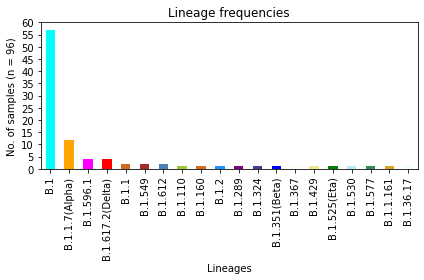

In [183]:
import math
# plot lineage frequencies
colors = [clr_code[lin][1] for lin in lins]
n = df_report_fnl['Pango Lineage Annotation'].count()
yticks = np.arange(0, (math.ceil(max_count / 5) + 1) * 5, 5)
fig, ax = plt.subplots()
(df_report_fnl['Pango Lineage Annotation']
 .value_counts()
 .plot(kind='bar', ax=ax, color=colors))
plt.title('Lineage frequencies')
plt.xlabel('Lineages')
plt.yticks(yticks)
plt.xticks(ticks=range(len(lins)), rotation=90, labels=xlabels)
plt.ylabel(f'No. of samples (n = {n})')
plt.tight_layout()
# fig.savefig('/home/douso/SarsGenomics/Processed/policy-brief-P006-corr.png', dpi=300.0)
plt.show()